# Распознавание жанра музыки по характеристикам трека

Цель проекта: проанализировать характеристики каждого трека в датасете и разработать модель, которая распознает жанры в тестовом датасете с максимальной метрикой F1.

## 1. Подготовка к работе

Подключаем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import phik
from catboost import CatBoostClassifier
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from ydata_profiling import ProfileReport
import shap

Загружаем датасеты. Сразу же проставляем индекс и меняем его тип с `float` на `int`.

In [2]:
df_train = pd.read_csv('./kaggle_music_genre_train.csv')
df_test = pd.read_csv('./kaggle_music_genre_test.csv')
df_train['instance_id'] = df_train['instance_id'].astype('int')
df_train = df_train.set_index('instance_id')
df_test['instance_id'] = df_test['instance_id'].astype('int')
df_test = df_test.set_index('instance_id')

## 2. Первичный обзор датасета

In [ ]:
ProfileReport(df_train, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Видно, что `key`, `mode` и `tempo` имеют пропущенные значения, а `duration_ms` имеет значение `-1`, что можно считать как пропущенное. 

Также есть немного дубликатов. 

И корреляция некоторых признаков. Но это в дальнейшем для модели неважно, т.к. из всех преобразований признаков выяснилось, что наилучшие результаты дает модель без изменения этих признаков. Об этом ниже.

## 3. Преобразование признаков

Самая популярная тональность в датасете: `C`. Заполним ей пропущенную тональность:

In [4]:
df_train['key'].fillna('C', inplace=True)
df_test['key'].fillna('C', inplace=True)

Для каждой тональности выберем наиболее популярный лад и заполним им пропущенные значения:

In [5]:
most_popular_modes = df_train.groupby('key')['mode'].agg(pd.Series.mode)
df_train['mode'] = df_train.apply(lambda x: x['mode'] if pd.notnull(x['mode']) else most_popular_modes[x['key']], axis=1)
df_test['mode'] = df_test.apply(lambda x: x['mode'] if pd.notnull(x['mode']) else most_popular_modes[x['key']], axis=1)


Примечательно, что если не заполнять пропущенные значения `tempo`, то результат получается лучше.

In [6]:
# df_train['tempo'].fillna(df_train['tempo'].mean(), inplace=True)
# df_test['tempo'].fillna(df_train['tempo'].mean(), inplace=True)

Пропущенные значения длительности заполним медианой:

In [7]:
mean_duration = df_train[df_train['duration_ms'] > -1]['duration_ms'].mean()
df_train.loc[df_train['duration_ms'] == -1, 'duration_ms'] = mean_duration
df_test.loc[df_test['duration_ms'] == -1, 'duration_ms'] = mean_duration

## 4. Модель

Ряд экспериментов показал, что наилучший алгоритм для решения этой задачи: `CatBoost`. А также то, что лучше всего он выдает результаты, если оставить все признаки как есть, включая дату добавления трека и его название. Поэтому используем как есть.

In [8]:
target = df_train['music_genre']
features = df_train.drop('music_genre', axis=1)
test_features = df_test

Делим выборки на тренировочную и валидационную:

In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(features, target, train_size=0.75, random_state=12345)

Задаем список категорийных признаков для `CatBoost`:

In [10]:
categorical_features_indices = ['key', 'mode', 'obtained_date', 'track_name']

Создаем и учим модель (здесь я намеренно не используют GridSearchCV и подобное, т.к. уже экспериментировал с ним с лесом и деревьями):

In [11]:
model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='TotalF1',
    custom_metric='F1',
    random_seed=12345,
    logging_level='Silent',
    # text_processing=Tokenizer(),
    # iterations=100, 
    # depth=8, 
    learning_rate=0.01
)

model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Предсказываем жанр для валидационной выборки:

In [12]:
predictions_valid = model.predict(X_validation)

Оцениваем F1 score:

In [13]:
print(f1_score(y_validation, predictions_valid, average='micro'))

0.49597960384389095


Предсказываем значения для тестовой выборки и сохраняем их:

In [14]:
predictions = model.predict(test_features)
pd.DataFrame(data=predictions, index=test_features.index, columns=['music_genre']).to_csv('./catboost_final.csv', header=True, index=True)

## 5. Анализ важности признаков

In [15]:
columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

In [16]:
corr = df_train.phik_matrix(interval_cols=columns)

The number of unique values of variable track_name is large: 18643. Are you sure this is not an interval variable? Analysis for pairs of variables including track_name can be slow.


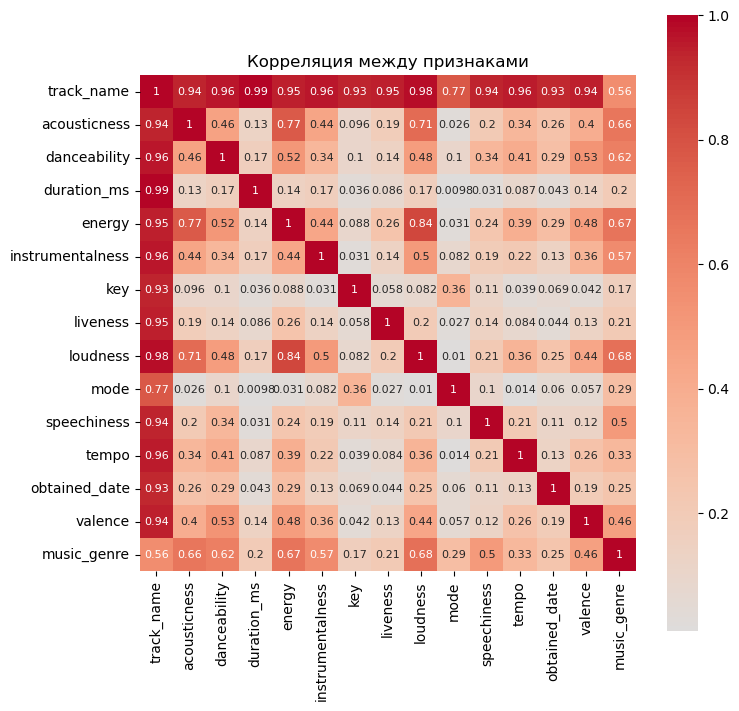

In [17]:
plt.figure(figsize=(8,8))
sns.heatmap(corr, vmax=1, square=True, annot=True, cmap='coolwarm', center=0, annot_kws={'size': 8})
plt.title("Корреляция между признаками")
plt.show()

По неизвестной мне причине heatmap не отображается, если включен ProfileReport. Придется ориентироваться по таблице:

In [18]:
corr

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
track_name,1.000000,0.940275,0.958920,0.992479,0.946566,0.957632,0.934620,0.945594,0.979274,0.773766,0.936447,0.956917,0.931697,0.942297,0.560513
acousticness,0.940275,1.000000,0.458491,0.133282,0.766657,0.441997,0.096245,0.185885,0.709364,0.026205,0.204106,0.336114,0.260666,0.397133,0.657653
danceability,0.958920,0.458491,1.000000,0.169126,0.516204,0.342605,0.099973,0.135120,0.483332,0.100553,0.335523,0.407472,0.285084,0.531502,0.623224
duration_ms,0.992479,0.133282,0.169126,1.000000,0.142828,0.170244,0.035711,0.086485,0.170046,0.009777,0.031012,0.087432,0.043444,0.137834,0.198283
energy,0.946566,0.766657,0.516204,0.142828,1.000000,0.437427,0.088133,0.256748,0.839273,0.031186,0.239284,0.387013,0.292828,0.478888,0.669221
instrumentalness,0.957632,0.441997,0.342605,0.170244,0.437427,1.000000,0.030666,0.138175,0.498359,0.082314,0.190934,0.218501,0.134738,0.357175,0.567686
key,0.934620,0.096245,0.099973,0.035711,0.088133,0.030666,1.000000,0.058153,0.082014,0.359720,0.112308,0.039315,0.069193,0.041896,0.165421
liveness,0.945594,0.185885,0.135120,0.086485,0.256748,0.138175,0.058153,1.000000,0.199227,0.027030,0.138512,0.084412,0.043832,0.130656,0.208943
loudness,0.979274,0.709364,0.483332,0.170046,0.839273,0.498359,0.082014,0.199227,1.000000,0.009983,0.211301,0.357614,0.254714,0.437069,0.679369
mode,0.773766,0.026205,0.100553,0.009777,0.031186,0.082314,0.359720,0.027030,0.009983,1.000000,0.101684,0.013934,0.059713,0.056661,0.289614


По таблице мы видим, что название трека имеет высокую корреляцию со всеми признаками, и среднюю с жанром. Скорее всего связано с уникальностью названий треков и их количеством.

Дата добавления же напротив имеет низкую корреляцию со всеми признаками. Но добавление их в модель повышает качество работы модели.

Наибольшее влияние на таргет оказывают `acousticness`, `danceability`, `energy`, `instrumentalness`, `loudness` и `speechness`. В принципе этого могло быть достаточно для модели. Но работа только с этими признаками дает намного более худшие результаты.

In [19]:
shap_test = shap.TreeExplainer(model).shap_values(features)

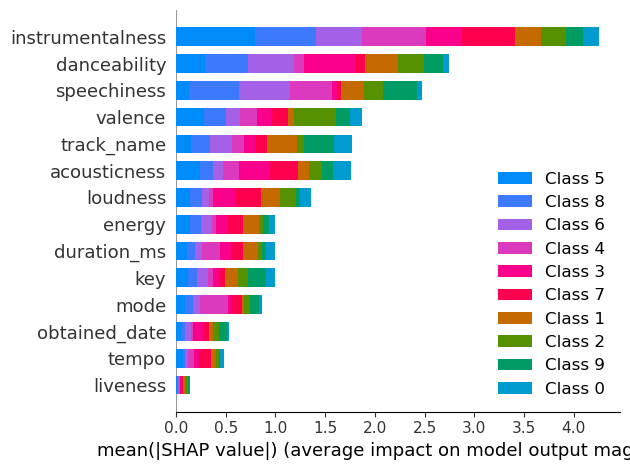

In [20]:
shap.summary_plot(shap_test, features, max_display=25, plot_size=None)

Из графика заметно что наибольшее влияние на жанр оказывают признаки `instrumentalness`, `danceability`, `speechiness` и `valence`.